In [1]:

from os import getcwd, listdir
from os.path import join, isdir
from pathlib import Path
from matplotlib.pyplot import axis, imshow, show, figure, title, subplot, plot, legend
from keras import layers, losses, optimizers, Sequential, backend, utils, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow import data, train
from numpy import argmax
from gc import collect

# Constants

In [2]:
IMG_SIZE = 224
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.3
SEED = 123
ALL_PATH = join(Path(getcwd()).parents[0], 'dataset', 'manually_cleaned_data')
CATEGORIES = sorted([ dir_name for dir_name in listdir(ALL_PATH) if isdir(join(ALL_PATH, dir_name)) ])

# Import dataset

In [3]:
train_ds, valid_ds = utils.image_dataset_from_directory(ALL_PATH,
                                                        #color_mode = 'grayscale',
                                                        subset = 'both',
                                                        label_mode = 'categorical',
                                                        validation_split = VALIDATION_SPLIT,
                                                        seed = SEED,
                                                        image_size = (IMG_SIZE, IMG_SIZE),
                                                        batch_size = BATCH_SIZE,
                                                        shuffle = True
                                                        )

count = data.experimental.cardinality(valid_ds)
test_ds = valid_ds.take(count // 5)
valid_ds = valid_ds.skip(count // 5)

print('Number of validation batches: %d' % data.experimental.cardinality(valid_ds))
print('Number of test batches: %d' % data.experimental.cardinality(test_ds))

Found 779 files belonging to 5 classes.
Using 546 files for training.
Using 233 files for validation.
Number of validation batches: 4
Number of test batches: 0


# Dataset visualization

9 total batches
(64, 224, 224, 3) (64, 5)


2024-03-29 12:52:21.684197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [546]
	 [[{{node Placeholder/_0}}]]
2024-03-29 12:52:21.684394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [546]
	 [[{{node Placeholder/_4}}]]
2024-03-29 12:52:21.688928: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


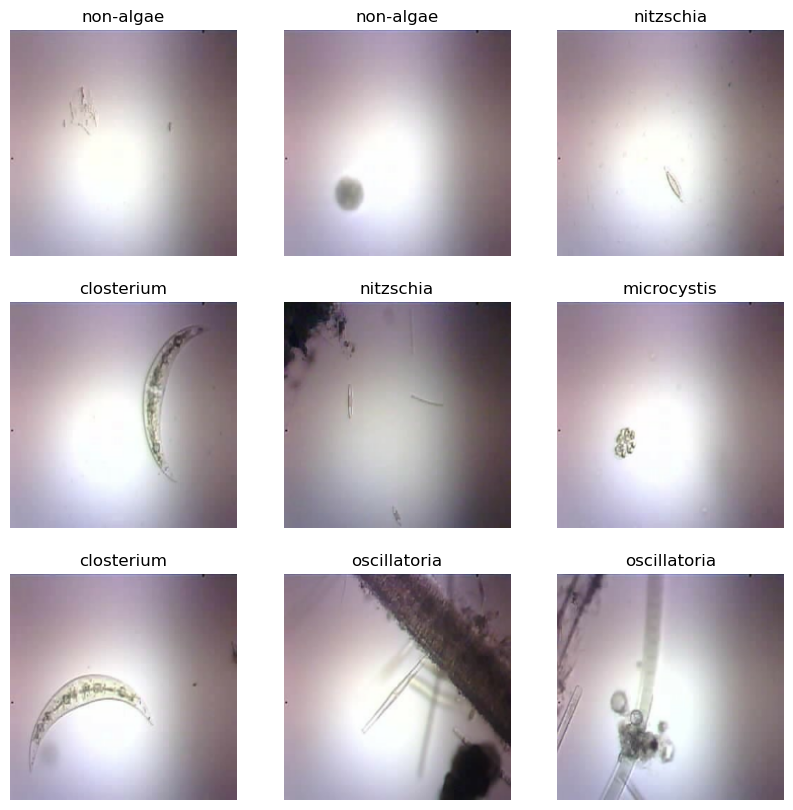

In [4]:
print(len(train_ds), 'total batches')

figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    print(images.shape, labels.shape)
    for i in range(9):
        ax = subplot(3, 3, i + 1)
        imshow(images[i].numpy().astype("uint8"))
        title(CATEGORIES[labels[i].numpy().argmax()])
        axis("off")

In [5]:
def reset_keras(model, has_model: bool = True):
    backend.clear_session()
    if has_model: del model
    collect()

In [6]:
model_shape = images.shape[1:]

# Build and compile model

In [7]:
reset_keras(None, False)

# Prefetching samples in GPU memory helps maximize GPU utilization
train_ds = train_ds.shuffle(1000).prefetch(data.AUTOTUNE).cache()
valid_ds = valid_ds.prefetch(data.AUTOTUNE).cache()
test_ds = test_ds.prefetch(data.AUTOTUNE).cache()

def build_model():
  model = Sequential([
    layers.Input(shape = model_shape),# batch_size=images.shape[0]),
    layers.RandomFlip("horizontal_and_vertical", input_shape = model_shape),
    layers.Rescaling(1. / 255),

    layers.Conv2D(filters = 64, kernel_size = 5, strides = 2, padding = "valid", activation = "relu"),
    layers.MaxPooling2D(pool_size = 3, strides = 2),
    layers.BatchNormalization(momentum = 0.9),

    layers.Conv2D(filters = 64, kernel_size = 5, strides = 2, padding = "same", activation = "relu"),
    layers.MaxPooling2D(pool_size = 3, strides = 1),
    layers.BatchNormalization(momentum = 0.9),

    layers.Conv2D(filters = 128, kernel_size = 5, strides = 2, padding = "same", activation = "relu"),
    layers.MaxPooling2D(pool_size = 3, strides = 1),
    layers.BatchNormalization(momentum = 0.9),

    layers.Dropout(0.1),

    layers.Flatten(),

    layers.Dense(1024, activation = "relu"),# input_shape=(prod(image_batch.shape[1:]),)),
    layers.BatchNormalization(momentum = 0.9),

    layers.Dense(1024, activation = "relu"),
    layers.BatchNormalization(momentum = 0.9),
      
    layers.Dense(len(CATEGORIES), activation = "softmax")
  ])

  return model

In [8]:
def compile(model) -> None:
    model.compile(optimizer = optimizers.legacy.Adam(learning_rate = 1e-5),
                  loss = losses.CategoricalCrossentropy(from_logits = False),
                  metrics = [ metrics.CategoricalAccuracy("accuracy") ]
                 )

# Train model

In [11]:
EPOCHS = 25
VERBOSE = 1
PATIENCE = 20
MONITOR = "val_loss"
MODE = "min"
MODEL_PATH = "../model_weights"

EARLY = EarlyStopping(monitor = MONITOR,
                      patience = PATIENCE,
                      verbose = VERBOSE,
                      mode = MODE,
                      restore_best_weights = True
                      )

CHECKPOINT = ModelCheckpoint(join(MODEL_PATH, "model.ckpt"),
                             monitor = MONITOR,
                             verbose = VERBOSE,
                             save_best_only = True,
                             save_weights_only = True,
                             mode = MODE
                             )

def fit(model):
    return model.fit(train_ds,
                     validation_data = valid_ds,
                     epochs = EPOCHS,
                     verbose = VERBOSE,
                     shuffle = True,
                     callbacks = [ CHECKPOINT, EARLY ]
                     )

model = build_model()
compile(model)

history = fit(model)
model.summary()

Epoch 1/25
25/25 [==============================] - ETA: 0s - loss: 1.9672 - accuracy: 0.2627
Epoch 1: val_loss improved from inf to 1.67170, saving model to ../model_weights/model.ckpt
25/25 [==============================] - 6s 220ms/step - loss: 1.9672 - accuracy: 0.2627 - val_loss: 1.6717 - val_accuracy: 0.3333
Epoch 2/25
25/25 [==============================] - ETA: 0s - loss: 1.6606 - accuracy: 0.3895
Epoch 2: val_loss did not improve from 1.67170
25/25 [==============================] - 5s 202ms/step - loss: 1.6606 - accuracy: 0.3895 - val_loss: 1.7792 - val_accuracy: 0.3540
Epoch 3/25
25/25 [==============================] - ETA: 0s - loss: 1.5042 - accuracy: 0.4285
Epoch 3: val_loss improved from 1.67170 to 1.38194, saving model to ../model_weights/model.ckpt
25/25 [==============================] - 5s 211ms/step - loss: 1.5042 - accuracy: 0.4285 - val_loss: 1.3819 - val_accuracy: 0.4539
Epoch 4/25
25/25 [==============================] - ETA: 0s - loss: 1.4374 - accuracy: 0.4

In [13]:
model.load_weights(train.latest_checkpoint(MODEL_PATH))
model.save(join(MODEL_PATH, "model.keras"))
model.save_weights(join(MODEL_PATH, "model_weights"))

# Evaluate accuracy

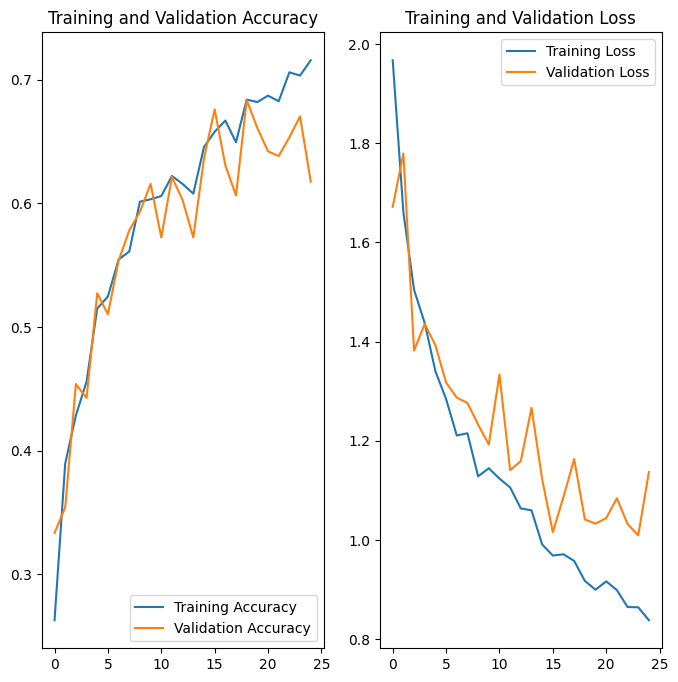

In [14]:
acc, val_acc = history.history["accuracy"], history.history["val_accuracy"]
figure(figsize = (8, 8))
subplot(1, 2, 1)
plot(acc, label = "Training Accuracy")
plot(val_acc, label = "Validation Accuracy")
legend(loc = "lower right")
title("Training and Validation Accuracy")

loss, val_loss = history.history["loss"], history.history["val_loss"]
subplot(1, 2, 2)
plot(loss, label = "Training Loss")
plot(val_loss, label = "Validation Loss")
legend(loc = "upper right")
title("Training and Validation Loss")

show()

# Testing and predicting

2/2 [==============================] - 0s 50ms/step - loss: 0.8997 - accuracy: 0.7266
88.89% of predictions are correct


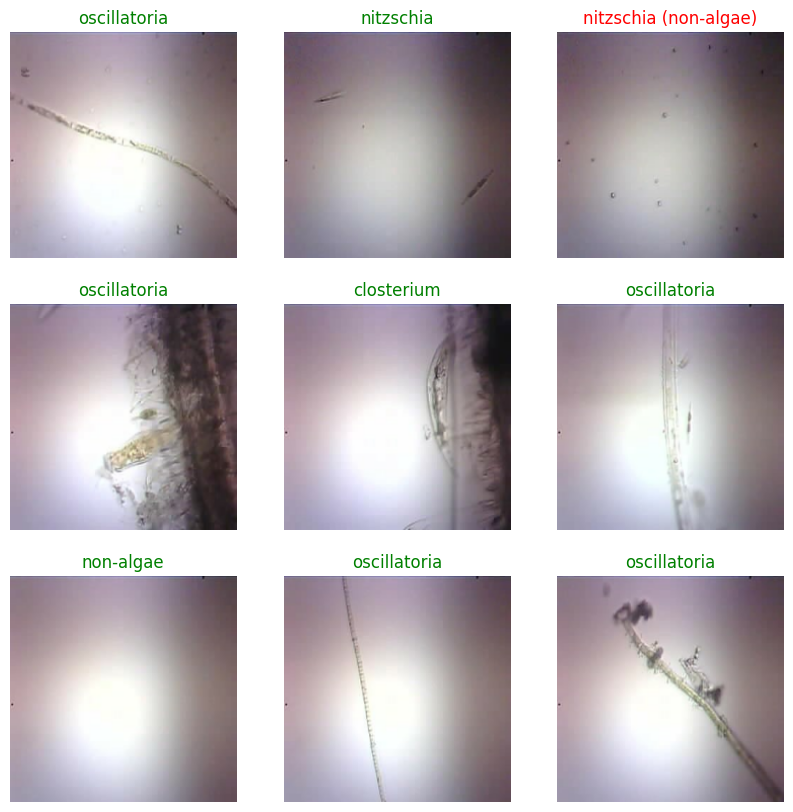

In [16]:
model.evaluate(test_ds, verbose = 1) # type: ignore
prediction = model.predict(test_ds, verbose = 0) # type: ignore
counter = 0
figure(figsize = (10, 10))

for images, labels in test_ds.take(1):
    for i in range(9):
        predict = CATEGORIES[argmax(prediction[i])]
        correct = CATEGORIES[argmax(labels[i].numpy())]
        img = images[i].numpy().astype("uint8")

        ax = subplot(3, 3, (i) + 1)
        axis("off")
        imshow(img)

        if predict == correct:
            title(predict, fontdict={'color': 'green'})
            counter += 1
        else: title(f"{predict} ({correct})", fontdict={'color': 'red'})

print(f"{counter / 9 * 100:.2f}% of predictions are correct")

In [ ]:
reset_keras(model)